In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

In [3]:
delight_path = '/content/drive/MyDrive/quality/train_label_img_resize_256/'
light_path = '/content/drive/MyDrive/quality/train_input_img_resize_256/'

In [4]:
import os

delight_img_path = []
light_img_path = []

for img_path in os.listdir(delight_path) :
    delight_img_path.append(os.path.join(delight_path, img_path))
    
for img_path in os.listdir(light_path) :
    light_img_path.append(os.path.join(light_path, img_path))

In [5]:
delight_img_path.sort()
light_img_path.sort()

In [6]:
from PIL import Image
from keras.preprocessing.image import img_to_array

X = []
y = []

for i in range(622):
    
    img1 = cv2.cvtColor(cv2.imread(delight_img_path[i]), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(light_img_path[i]), cv2.COLOR_BGR2RGB)
    
    y.append(img_to_array(Image.fromarray(cv2.resize(img1,(128,128)))))
    X.append(img_to_array(Image.fromarray(cv2.resize(img2,(128,128)))))

In [7]:
X = np.array(X)
y = np.array(y)

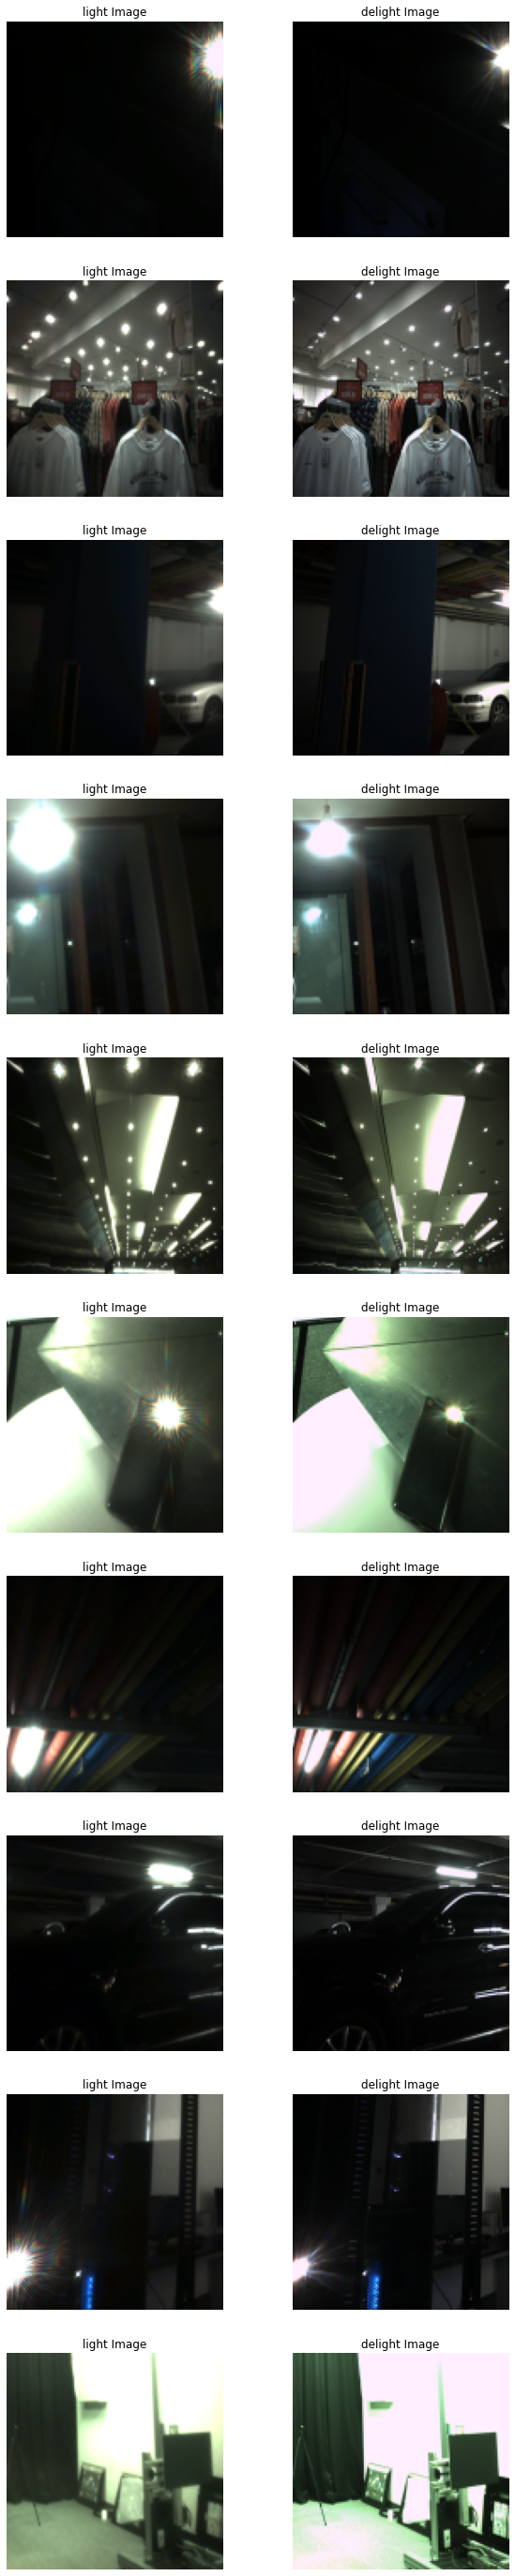

In [8]:
plt.figure(figsize = (10,50))

i = 0

while i < 20:
    
    x = np.random.randint(0,622)
    
    plt.subplot(10, 2, i+1)
    plt.imshow(X[x]/255.0,'gray')
    plt.axis('off')
    plt.title('light Image')
    
    plt.subplot(10, 2, i+2)
    plt.imshow(y[x]/ 255.0)
    plt.axis('off')
    plt.title('delight Image')
    i += 2
    
plt.show()

In [9]:
X = (X/127.5) - 1
y = (y/127.5) - 1

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle = False)

In [12]:
!pip install tensorflow-addons

     |████████████████████████████████| 679 kB 15.9 MB/s 


In [13]:
from tensorflow_addons.layers import SpectralNormalization
from keras.layers import BatchNormalization
from keras.layers import ZeroPadding2D
from keras.layers import Concatenate
from keras.layers import Activation
from keras.models import Model
from keras.layers import Dense
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Conv2DTranspose
from keras.initializers import RandomNormal
from tensorflow_addons.layers import InstanceNormalization

In [14]:
init = RandomNormal(mean = 0.0, stddev = 0.02)

In [15]:
def d_block (x_input, filters, strides, padding, batch_norm, inst_norm) :
    
    x = Conv2D(filters, (4, 4),
               strides=strides,
               padding=padding,
               use_bias= False,
               kernel_initializer = init)(x_input)
    
    '''
    SpectralNormalization is wrapped around convolution layer.
    Also, Instance  and  Batch Normalization layers are added.
    '''
    
    if batch_norm == True :
        x = BatchNormalization   ()(x)
    if inst_norm  == True :
        x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)
    return x


def u_block (x, skip, filters, strides, padding, batch_norm, inst_norm) :
    
    x = Conv2DTranspose(filters, (4, 4),
                        strides=strides,
                        padding=padding,
                        use_bias= False,
                        kernel_initializer = init)(x)
    
    '''
    All the 3 normalizations applied here as well.
    '''
    
    if batch_norm == True :
        x = BatchNormalization   ()(x)
    if inst_norm  == True :
        x = InstanceNormalization()(x)
    x = ReLU()(x)
    conc_x = Concatenate()([x , skip])
    
    return conc_x

In [16]:
def PatchGAN (image_shape) :
    
    genI = Input(shape =  image_shape)
    tarI = Input(shape =  image_shape)
    conc = Concatenate()([genI, tarI])
    
    c064 = d_block(conc, 2**6, 2, 'same', False, False)
    c128 = d_block(c064, 2**7, 2, 'same', False, True )
    c256 = d_block(c128, 2**8, 2, 'same', True , False)
    
    temp = ZeroPadding2D()(c256)
    
    c512 = d_block(temp, 2**9, 1,'valid', True , False)
    
    temp = ZeroPadding2D()(c512)
    
    c001 = Conv2D(2**0, (4,4), strides=1, padding = 'valid', activation = 'sigmoid', kernel_initializer=init)(temp)
    
    model = Model(inputs = [genI, tarI], outputs = c001)
    return model

In [17]:
d_model = PatchGAN((128,128,3,))
d_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   6144        concatenate[0][0]            

In [18]:
def mod_Unet () :
    
    srcI = Input(shape = (128,128,3,))
    
    # Contracting path
    
    c064 = d_block(srcI, 2**6, 2, 'same', False, False) # _______________________.
    c128 = d_block(c064, 2**7, 2, 'same', True , False) # ____________________.  .
    c256 = d_block(c128, 2**8, 2, 'same', True , False) # _________________.  .  .
    c512 = d_block(c256, 2**9, 2, 'same', True , False) # ______________.  .  .  .
    d512 = d_block(c512, 2**9, 2, 'same', True , False) # ___________.  .  .  .  .
    e512 = d_block(d512, 2**9, 2, 'same', True , False) # ________.  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    # Bottleneck layer                                            .  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    f512 = d_block(e512, 2**9, 2, 'same', True , False) #         .  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    # Expanding  path                                             .  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    u512 = u_block(f512, e512, 2**9, 2, 'same', True, False)# ____.  .  .  .  .  .
    u512 = u_block(u512, d512, 2**9, 2, 'same', True, False)# _______.  .  .  .  .
    u512 = u_block(u512, c512, 2**9, 2, 'same', True, False)# __________.  .  .  .
    u256 = u_block(u512, c256, 2**8, 2, 'same', True, False)# _____________.  .  .
    u128 = u_block(u256, c128, 2**7, 2, 'same', True, False)# ________________.  .
    u064 = u_block(u128, c064, 2**6, 2, 'same', False, True)# ___________________.
    
    genI = Conv2DTranspose(3, (4,4), strides = 2, padding = 'same', activation = 'tanh', kernel_initializer = init)(u064)
    
    model = Model(inputs = srcI, outputs = genI)
    return model

In [19]:
g_model = mod_Unet()
g_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 64)   3072        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 64, 64, 64)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 128)  131072      leaky_re_lu_4[0][0]              
____________________________________________________________________________________________

In [20]:
LAMBDA = 100
BATCH_SIZE = 16
BUFFER_SIZE  = 400

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [22]:
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE)
valid_dataset = valid_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE)

In [23]:
gen0 = mod_Unet()

'''
Using the idea of multi-scale discriminator from [4]. We  use three
discriminators downsampling the input volume by a factor of 2 and 4.
'''

dis0 = PatchGAN((128,128,3,)) # (W//1) x (H//1)
dis1 = PatchGAN((64, 64, 3,)) # (W//2) x (H//2)
dis2 = PatchGAN((32, 32, 3,)) # (W//4) x (H//4)

In [24]:
bin_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

In [25]:
def gen_loss (dis_gen_output, target_image, gen_output) :
    
    ad_loss = bin_entropy(tf.ones_like (dis_gen_output) ,  dis_gen_output)
    l1_loss = tf.reduce_mean(tf.abs(tf.subtract(target_image,gen_output)))
    

    total_loss = ad_loss + (LAMBDA*l1_loss)
    
    return total_loss, ad_loss, l1_loss

In [26]:
def dis_loss (dis_gen_output, dis_tar_output) :
    
    gen_loss = bin_entropy(tf.zeros_like(dis_gen_output), dis_gen_output)
    tar_loss = bin_entropy(tf.ones_like (dis_tar_output), dis_tar_output)
    
    total_dis_loss = gen_loss + tar_loss
    return total_dis_loss

In [27]:
g_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)
d0optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)
d1optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)
d2optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)

In [28]:
@tf.function
def train_on_batch (b_w_image, tar_image) :
    
    with tf.GradientTape(persistent = True) as  g :
        
        '''
        Image Tensors
        '''
        gen_image = gen0(b_w_image, training=True)
        
        # 128x128
        dis_tar_output_128 = dis0([b_w_image, tar_image], training = True)
        dis_gen_output_128 = dis0([b_w_image, gen_image], training = True)
        
        
        tar_image_128 = tar_image
        gen_image_128 = gen_image
        
        tar_image = tf.image.resize(tar_image, [64,64])
        b_w_image = tf.image.resize(b_w_image, [64,64])
        gen_image = tf.image.resize(gen_image, [64,64])
        
        # 064x064
        dis_tar_output_064 = dis1([b_w_image, tar_image], training = True)
        dis_gen_output_064 = dis1([b_w_image, gen_image], training = True)
        
        tar_image_064 = tar_image
        gen_image_064 = gen_image
        
        tar_image = tf.image.resize(tar_image, [32,32])
        b_w_image = tf.image.resize(b_w_image, [32,32])
        gen_image = tf.image.resize(gen_image, [32,32])
        
        # 032x032
        dis_tar_output_032 = dis2([b_w_image, tar_image], training = True)
        dis_gen_output_032 = dis2([b_w_image, gen_image], training = True)
        
        tar_image_032 = tar_image
        gen_image_032 = gen_image
        
        '''
        LOSS
        '''
        
        # 128x128
        g_loss_128, _, _ = gen_loss(dis_gen_output_128, tar_image_128, gen_image_128)
        d_loss_128 = dis_loss(dis_gen_output_128, dis_tar_output_128)
        
        # 064x064
        g_loss_064, _, _ = gen_loss(dis_gen_output_064, tar_image_064, gen_image_064)
        d_loss_064 = dis_loss(dis_gen_output_064, dis_tar_output_064)
        
        # 032x032
        g_loss_032, _, _ = gen_loss(dis_gen_output_032, tar_image_032, gen_image_032)
        d_loss_032 = dis_loss(dis_gen_output_032, dis_tar_output_032)
        
        
        g_total_loss = g_loss_128 + g_loss_064 + g_loss_032
        d_total_loss = d_loss_128 + d_loss_064 + d_loss_032
    
    # compute gradients
    g_gradients = g.gradient(g_total_loss, gen0.trainable_variables) # generatorLoss
    
    d0gradients = g.gradient(d_loss_128, dis0.trainable_variables)   # dis loss 128
    d1gradients = g.gradient(d_loss_064, dis1.trainable_variables)   # dis loss 064
    d2gradients = g.gradient(d_loss_032, dis2.trainable_variables)   # dis loss 032
    
    
    # apply gradient descent
    g_optimizer.apply_gradients(zip(g_gradients, gen0.trainable_variables))
    
    d0optimizer.apply_gradients(zip(d0gradients, dis0.trainable_variables))
    d1optimizer.apply_gradients(zip(d1gradients, dis1.trainable_variables))
    d2optimizer.apply_gradients(zip(d2gradients, dis2.trainable_variables))

In [29]:
for global_b_w_image, global_tar_image in train_dataset.take(1) :
    pass

In [30]:
def fig (b_w_image, gen_image, tar_image) :
    
    plt.figure(figsize = (20, 20))
    
    plt.subplot(1,3,1)
    plt.imshow((b_w_image[0] + 1.0) / 2.0)
    plt.title('light Image',fontsize = 20)
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow((gen_image[0] + 1.0) / 2.0)
    plt.title('GenerateImg',fontsize = 20)
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow((tar_image[0] + 1.0) / 2.0)
    plt.title('delight Img',fontsize = 20)
    plt.axis('off')
    
    plt.show()

def fit (EPOCHS = 200) :
    
    for epoch in range(EPOCHS) :
        
        print(f'Epoch {epoch} out of {EPOCHS}')
        
        for n, (b_w_image, tar_image) in train_dataset.enumerate() :
            if n ==  622 :
                print('#....End')
            if n%20 == 0 :
                print('#',end='')
            train_on_batch(b_w_image, tar_image)
        
        if epoch%3  == 0 :
            global_gen_image = gen0(global_b_w_image,training = True)
            fig(global_b_w_image, global_gen_image, global_tar_image)

In [31]:
fit(EPOCHS = 50)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
test_path = '/content/drive/MyDrive/quality/test_input_img_resize_256/'

In [33]:
import os

test_img_path = []

for img_path in os.listdir(test_path) :
    test_img_path.append(os.path.join(test_path, img_path))

In [34]:
test_img_path.sort()

In [35]:
from PIL import Image
from keras.preprocessing.image import img_to_array

X = []
Y_test = []

for i in range(20):  
    img1 = cv2.cvtColor(cv2.imread(test_img_path[i]), cv2.COLOR_BGR2RGB) 
    Y_test.append(img_to_array(Image.fromarray(cv2.resize(img1,(128,128)))))

In [36]:
Y_test = np.array(Y_test)

Y_test = (Y_test/127.5) - 1

In [37]:
from zipfile import *

In [38]:
# from zipfile import *
# sub_imgs = []
# for i, img in enumerate(Y_test):
#     path = f'test_{20000+i}.png'
#     cv2.imwrite(path, img)
#     sub_imgs.append(path)
# submission = zipfile.ZipFile("submission.zip", 'w')